In [2]:
%reload_ext autoreload
%autoreload 2

In [ ]:
from copy import copy
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from example import generate_points, voronoi_patches, transform_patches, add_noise, noise_profile
from l2gx.patch.patches import Patch
from l2gx.align import get_aligner, procrustes_error, AlignmentProblem
from umap import UMAP

# <font color="grey"> Synthetic data</font>

In this experiment, we generate a point cloud consisting of $5$ normal distributed clusters. We then subdivide this point cloud into $10$ overlapping patches.

In [4]:
points = generate_points(n_clusters=5, scale=1.0, std=0.2, max_size=2000, min_size=128, dim=2)
patches, centres = voronoi_patches(points, sample_size=10, min_degree=4, min_overlap=64, min_patch_size=128, eps=1, kmeans=False)

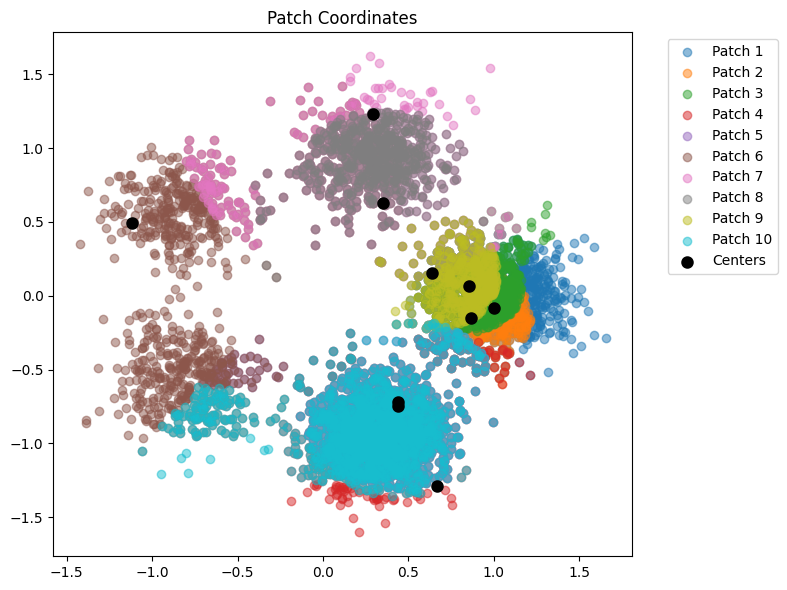

In [6]:
plt.figure(figsize=(8, 6))
for i in range(len(patches)):
    plt.scatter(patches[i].coordinates[:, 0], patches[i].coordinates[:, 1], alpha=0.5, label=f'Patch {i+1}')
plt.scatter(centres[:, 0], centres[:, 1], alpha=1, label='Centers', c='black', linewidths=3)
plt.title('Patch Coordinates')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
noise_levels = np.linspace(0.0, 0.1, 10)
dims = [2, 8]
T = 100
mean_errors = {}
std_errors = {}

In [ ]:
aligner = get_aligner("l2g")

In [ ]:
def run_experiment(dims: list[int], noise_levels: list[float], T: int, aligner: AlignmentProblem):
    mean_errors = {}
    std_errors = {}
    for d in dims:
        points = generate_points(n_clusters=5, scale=1.0, std=0.2, max_size=2000, min_size=128, dim=d)
        error_matrix = np.zeros((T, len(noise_levels)))
        for t in tqdm(range(T)):
            patches, _ = voronoi_patches(points, sample_size=10, min_degree=4, min_overlap=64, min_patch_size=128, eps=2, kmeans=False)
            for i, noise in enumerate(noise_levels):
                noisy_patches = add_noise(patches, noise, scales=None)
                transformed_patches = transform_patches(noisy_patches, shift_scale=10.0, scale_range=[0.1, 10])
                try:
                    aligner.align_patches(transformed_patches, min_overlap=64)
                except:
                    continue
                embedding = aligner.get_aligned_embedding()
                error_matrix[t, i] = procrustes_error(points, embedding)
        # Compute mean and standard deviation of errors for each noise level
        mean_errors[d] = np.mean(error_matrix, axis=0)
        std_errors[d] = np.std(error_matrix, axis=0)
    return mean_errors, std_errors

In [ ]:
points = generate_points(n_clusters=5, scale=1.0, std=0.2, max_size=2000, min_size=128, dim=2)


In [ ]:
def run_geo_experiment(points: np.ndarray, lr: float, epochs=list[int], noise_level=0.001):
    patches, _ = voronoi_patches(points, sample_size=10, min_degree=4, min_overlap=64, min_patch_size=128, eps=1, return_graph=False, kmeans=False)
    noisy_patches = add_noise(patches, noise_level, scales=None)
    transformed_patches = transform_patches(noisy_patches, shift_scale=1.0, scale_range=None)
    errors = np.zeros(len(epochs))
    embedding = {}
    for epoch in epochs:
        print(f"Epoch {epoch}")
        aligner = get_aligner("geo")
        aligner.set_learning_rate(lr)
        aligner.set_num_epochs(epoch)
        aligner.align_patches(transformed_patches, min_overlap=64)
        embedding[f"{epoch}"] = aligner.get_aligned_embedding()
        errors[i] = procrustes_error(points, embedding[f"{epoch}"])
    return errors, embedding

In [ ]:
geo_aligner = get_aligner("geo")

In [ ]:
T = 10
epochs = [100*i for i in range(1,31)]
errors = np.zeros((len(epochs), T))
for t in range(T):
    errors[:,t], _ = run_geo_experiment(points, 0.1, epochs)

In [ ]:
mean_procrustes_errors = np.mean(errors, axis=1)
std_procrustes_errors = np.std(errors, axis=1)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].scatter(points[:, 0], points[:, 1], alpha=0.5)
ax[0].set_title('Groundtruth embedding')
ax[1].errorbar(epochs, 
             mean_procrustes_errors, 
             yerr=std_procrustes_errors/5, 
             label='GeoAlignment',
             elinewidth=2,
             capsize=2,
             capthick=1)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Procrustes Error')
ax[1].set_title('Procrustes Error vs Epochs')
plt.savefig('geo_alignment_error.pdf')

In [ ]:
error_matrix

In [ ]:
plt.plot(error_matrix)
plt.show()

In [ ]:
plt.scatter(embedding[f"{epochs[-1]}"][:, 0], embedding[f"{epochs[-1]}"][:, 1], alpha=0.5)
plt.scatter(points[:, 0], points[:, 1], alpha=0.5)
plt.show()

In [ ]:
mean_errors, std_errors = run_experiment(dims, noise_levels, T, aligner)

In [ ]:
plt.figure(figsize=(10, 6))
# Plot error curves for all dimensions
for dim in dims:
        plt.errorbar(noise_levels, 
                     mean_errors[dim], 
                     yerr=std_errors[dim], 
                     label=f'Dimension {dim}',
                     elinewidth=1,
                     capsize=3,
                     capthick=2)

plt.xlabel('Noise Level')
plt.ylabel('Procrustes Error')
plt.title(f'Error vs Noise Level (Dimension {2})')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#points = generate_points(n_clusters=5, scale=1.0, std=0.2, max_size=2000, min_size=128, dim=2)
patches, centers = voronoi_patches(points, sample_size=10, min_degree=4, min_overlap=64, min_patch_size=128, eps=2, return_graph=False, kmeans=False)
noisy_patches = add_noise(patches, 0.01, scales=None)
transformed_patches = transform_patches(noisy_patches, shift_scale=1, scale_range=[0.1, 10])


In [ ]:
geo_aligner = get_aligner(
    "geo",
    num_epochs=20000,
    learning_rate=0.001,
    model_type="affine")

In [ ]:
geo_aligner.align_patches(transformed_patches, min_overlap=64)
embedding = geo_aligner.get_aligned_embedding()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
# Plot original patches
for i in range(len(patches)):
    ax[0].scatter(patches[i].coordinates[:, 0], patches[i].coordinates[:, 1], alpha=0.5, label=f'Patch {i}')
ax[0].set_aspect('equal')  # Ensure equal scaling for x and y axes

# Set up for transformed patches
for patch in transformed_patches:
    ax[1].scatter(patch.coordinates[:, 0], patch.coordinates[:, 1], alpha=0.5)
ax[1].set_aspect('equal')  # Ensure equal scaling for x and y axes

# Plot aligned patches
ax[2].scatter(embedding[:, 0], embedding[:, 1], alpha=0.5)
ax[2].set_aspect('equal')  # Ensure equal scaling for x and y axes

plt.show()

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
for i in range(3):
    for j in range(3):
        ax[i, j].scatter(geo_aligner.patches[3*i+j].coordinates[:, 0], geo_aligner.patches[3*i+j].coordinates[:, 1], alpha=0.5, label=f'Patch {3*i+j}')
        ax[i, j].scatter(patches[3*i+j].coordinates[:, 0], patches[3*i+j].coordinates[:, 1], alpha=0.5, label=f'Patch {3*i+j}')
        #ax[i, j].scatter(transformed_patches[3*i+j].coordinates[:, 0], transformed_patches[3*i+j].coordinates[:, 1], alpha=0.5, label=f'Patch {3*i+j}')
        # Add a legend with different colors for each type of patch
        ax[i, j].legend(['GeoAligned', 'Original', 'Transformed'], loc='upper right')
        ax[i, j].set_aspect('equal')  # Ensure equal scaling for x and y axes
        ax[i, j].set_title(f'Patch {3*i+j}')
plt.show()

In [ ]:
mean_errors, std_errors = run_experiment(dims, noise_levels, T, geo_aligner)

In [ ]:
plt.figure(figsize=(10, 6))
# Plot error curves for all dimensions
for dim in dims:
        plt.errorbar(noise_levels, 
                     mean_errors[dim], 
                     yerr=std_errors[dim], 
                     label=f'Dimension {dim}',
                     elinewidth=1,
                     capsize=3,
                     capthick=2)

plt.xlabel('Noise Level')
plt.ylabel('Procrustes Error')
plt.title(f'Error vs Noise Level (Dimension {2})')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
for key in geo_aligner.intersections:
    print(key, len(geo_aligner.intersections[key]))

In [ ]:
plt.plot(geo_aligner.loss_hist)
plt.show()